In [1]:
import zipfile
import tarfile

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import csv

import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import torch
import numpy as np


import random
from tqdm import tqdm

In [107]:
asd = torch.zeros((3,5))
asd[0:2, 1] = 5
asd

tensor([[0., 5., 0., 0., 0.],
        [0., 5., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [2]:
objectLayer = {}
with open('CorrispondenzeOggettiClasse.csv', mode='r') as f:
    lines = f.readlines()
    lines[0] = '0;0\n'
for line in lines:
    keyValue = line.split(';')
    objectLayer[int(keyValue[0])] = int(keyValue[1][:-1])

In [3]:
def checkSameBytes(firstBytes, secondBytes):
    for idx, b in enumerate(secondBytes):
        if firstBytes[idx] != b:
            return False
    return True

In [4]:
def instanceAllObjects(className, bytesArray, count, size):
    instanceList = []
    startByte = 0
    constructor = globals()[className]
    for o in range(0, count):
        instance = constructor(bytesArray[startByte:startByte + size])
        startByte += size
        instanceList.append(instance)
    return instanceList

In [5]:
def addZeros(bytesArray, finalSize):
    if(len(bytesArray) < finalSize):
        missingBytes = finalSize - len(bytesArray)
        zero = 0
        zeroByte = zero.to_bytes(1, 'little')
        bytesArray = bytesArray + (zeroByte * missingBytes)
    return bytesArray  

In [6]:
def fromListToBytes(objects, finalSize):
    objectsBytes =  bytearray()
    if len(objects) > 0:
        objectsBytesLists = list(map(lambda o: o.toBytes(), objects))
        objectsBytes = objectsBytesLists[0]
        for ob in objectsBytesLists[1:]:
            objectsBytes += ob
    return addZeros(objectsBytes, finalSize)    
    

In [7]:
class ObjectBytes(ABC):
    @abstractmethod
    def toBytes(self):
        pass

In [8]:
class GameObject(ObjectBytes):
    def __init__(self, objectBytes):
        self.xPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)
        self.middleTileX = True if self.xPosition % 160 != 0 else False
        self.xPosition = self.xPosition // 160
        self.middleTileY = True if self.yPosition % 160 != 0 else False
        self.yPosition = self.yPosition // 160
        self.padding = int.from_bytes(objectBytes[8:10],"little", signed = False)
        self.objectWidth = objectBytes[10]
        self.objectHeight = objectBytes[11]
        self.objectFlags = int.from_bytes(objectBytes[12:16],"little", signed = False)
        self.childObjectFlags = int.from_bytes(objectBytes[16:20],"little", signed = False)
        self.extendedData = int.from_bytes(objectBytes[20:24],"little", signed = False)
        self.objectType = int.from_bytes(objectBytes[24:26],"little", signed = False)
        self.childObjectType = int.from_bytes(objectBytes[26:28],"little", signed = False)
        self.linkID = int.from_bytes(objectBytes[28:30],"little", signed = False)
        self.soundEffect = int.from_bytes(objectBytes[30:32],"little", signed = False)
        self.layer = objectLayer[self.objectType]
        self.flagsType = int.from_bytes(objectBytes[12:16] + objectBytes[24:26],"little", signed = False)
        self.childFlagsType= int.from_bytes(objectBytes[16:20] + objectBytes[26:28],"little", signed = False)
    
    def toBytes(self):
        xPositionBytes = self.xPosition * 160
        yPositionBytes = self.yPosition * 160
        if self.middleTileX:
            xPositionBytes +=80
        if self.middleTileY:
            yPositionBytes +=80
        xBytes = xPositionBytes.to_bytes(4, 'little')
        yBytes = yPositionBytes.to_bytes(4, 'little')
        padding = self.padding.to_bytes(2, 'little')
        width = self.objectWidth.to_bytes(1, 'little')
        height = self.objectHeight.to_bytes(1, 'little')
        flags = self.objectFlags.to_bytes(4, 'little')
        childObjectFlags = self.childObjectFlags.to_bytes(4, 'little')
        extendedData = self.extendedData.to_bytes(4, 'little')
        objectType = self.objectType.to_bytes(2, 'little')
        childObjectType = self.childObjectType.to_bytes(2, 'little')
        linkID = self.linkID.to_bytes(2, 'little')
        soundEffect = self.soundEffect.to_bytes(2, 'little')
        return xBytes + yBytes + padding + width + height + flags + childObjectFlags + extendedData + objectType + childObjectType + linkID + soundEffect
    
    def __str__(self):
        return 'Tipo:' + str(self.objectType) + '\nPosizione:(' + str(self.xPosition) + ',' + str(self.yPosition) + ')' \
            + ('Ha figlio di tipo:' + str(self.childObjectType) if self.childObjectType != 65535 else 'non ha figlio')

In [9]:
class FreestandingSoundEffect(ObjectBytes):
    def __init__(self, soundBytes):
        self.effectType = soundBytes[0]
        self.xPosition = soundBytes[1]
        self.yPosition = soundBytes[2]
        self.padding = soundBytes[3]
        
    def toBytes(self):
        effectType = self.effectType.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return effectType + xPosition + yPosition + padding

In [10]:
class SnakeNode(ObjectBytes):
    def __init__(self, snakeNodeBytes):
        self.index = int.from_bytes(snakeNodeBytes[:2],"little", signed = False) #parte da zero
        self.direction = int.from_bytes(snakeNodeBytes[2:4],"little", signed = False)
        self.always100 = int.from_bytes(snakeNodeBytes[4:6],"little", signed = False)
        self.padding = int.from_bytes(snakeNodeBytes[6:8],"little", signed = False) 
        
    def toBytes(self):
        index = self.index.to_bytes(2, 'little')
        direction = self.direction.to_bytes(2, 'little')
        always100 = self.always100.to_bytes(2, 'little')
        padding = self.padding.to_bytes(2, 'little')
        return index + direction + always100 + padding

In [11]:
class SnakeBlockTrack(ObjectBytes):
    def __init__(self, snakeBytes):
        self.linkID = snakeBytes[0] #sarà 0 1 2 3 4?
        self.nodeCount = snakeBytes[1]
        self.always1 = snakeBytes[2]
        self.padding = snakeBytes[3]
        self.snakeNodes = instanceAllObjects('SnakeNode', snakeBytes[4:], self.nodeCount, 8)
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        snakeNodes = fromListToBytes(self.snakeNodes, 960)
        return linkID + nodeCount + always1 + padding + snakeNodes  

In [12]:
class ClearPipeNode(ObjectBytes):
    def __init__(self, clearPipeNodesBytes):
        self.unknownDirection = clearPipeNodesBytes[0]
        self.index = clearPipeNodesBytes[1]
        self.unKnowCoordinates = clearPipeNodesBytes[2]
        self.unKnowCoordinates2 = clearPipeNodesBytes[3]
        self.always2 = clearPipeNodesBytes[4]
        self.unknown = clearPipeNodesBytes[5] 
        self.always1 = clearPipeNodesBytes[6]
        self.unknown0123 = clearPipeNodesBytes[7]
        
    def toBytes(self):
        unknownDirection = self.unknownDirection.to_bytes(1, 'little')
        index = self.index.to_bytes(1, 'little')
        unKnowCoordinates = self.unKnowCoordinates.to_bytes(1, 'little')
        unKnowCoordinates2 = self.unKnowCoordinates2.to_bytes(1, 'little')
        always2 = self.always2.to_bytes(1, 'little')
        unknown = self.unknown.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        unknown0123 = self.unknown0123.to_bytes(1, 'little')
        return unknownDirection + index + unKnowCoordinates + unKnowCoordinates2 + always2 + unknown + always1 + unknown0123

In [13]:
class ClearPipe(ObjectBytes):
    def __init__(self, clearPipeBytes):
        self.linkID = clearPipeBytes[0]
        self.nodeCount = clearPipeBytes[1]
        self.always1 = clearPipeBytes[2]
        self.padding = clearPipeBytes[3]
        self.clearPipeNodes = instanceAllObjects('ClearPipeNode', clearPipeBytes[4:], self.nodeCount, 8)
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        clearPipeNodes = fromListToBytes(self.clearPipeNodes, 288)
        return linkID + nodeCount + always1 + padding + clearPipeNodes  

In [14]:
class PiranhaCreeperNode(ObjectBytes):
    def __init__(self, piranhaCreeperNodeBytes):
        self.always1 = piranhaCreeperNodeBytes[0] 
        self.direction = piranhaCreeperNodeBytes[1]
        self.always0_1 = piranhaCreeperNodeBytes[2]
        self.always0_2 = piranhaCreeperNodeBytes[3]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        always0_1 = self.always0_1.to_bytes(1, 'little')
        always0_2 = self.always0_2.to_bytes(1, 'little')
        return always1 + direction + always0_1 + always0_2

In [15]:
class PiranhaCreeperTrack(ObjectBytes):
    def __init__(self, piranhaCreeperTrackBytes):
        self.always1 = piranhaCreeperTrackBytes[0] 
        self.linkID = piranhaCreeperTrackBytes[1]
        self.nodeCount = piranhaCreeperTrackBytes[2]
        self.padding = piranhaCreeperTrackBytes[3]
        self.piranhaCreeperNodes = instanceAllObjects('PiranhaCreeperNode', piranhaCreeperTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        piranhaCreeperNodes = fromListToBytes(self.piranhaCreeperNodes, 80)
        return always1 + linkID + nodeCount + padding + piranhaCreeperNodes  

In [16]:
class ExpandingBlockNode(ObjectBytes):
    def __init__(self, expandingBlockNodeBytes):
        self.always1 = expandingBlockNodeBytes[0] 
        self.direction = expandingBlockNodeBytes[1]
        self.padding = expandingBlockNodeBytes[2:4] 
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding  

In [17]:
class ExpandingBlockTrack(ObjectBytes):
    def __init__(self, expandingBlockTrackBytes):
        self.always1 = expandingBlockTrackBytes[0] 
        self.linkID = expandingBlockTrackBytes[1]
        self.nodeCount = expandingBlockTrackBytes[2]
        self.padding = expandingBlockTrackBytes[3]    
        self.expandingBlockNodes = instanceAllObjects('ExpandingBlockNode', expandingBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        expandingBlockNodes = fromListToBytes(self.expandingBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + expandingBlockNodes      

In [18]:
class TrackBlockNode(ObjectBytes):
    def __init__(self, trackBlockNodeBytes):
        self.always1 = trackBlockNodeBytes[0]
        self.direction = trackBlockNodeBytes[1]
        self.padding = trackBlockNodeBytes[2:4]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding 

In [19]:
class TrackBlockTrack(ObjectBytes):
    def __init__(self, trackBlockTrackBytes):
        self.always1 = trackBlockTrackBytes[0] 
        self.linkID = trackBlockTrackBytes[1]
        self.nodeCount = trackBlockTrackBytes[2]
        self.padding = trackBlockTrackBytes[3]  
        self.trackBlockNodes = instanceAllObjects('TrackBlockNode', trackBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        trackBlockNodes = fromListToBytes(self.trackBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + trackBlockNodes  

In [20]:
class Tile(ObjectBytes):
    def __init__(self, tileBytes):
        self.xPosition = tileBytes[0]
        self.yPosition = tileBytes[1]
        self.tileID = tileBytes[2] 
        self.backgroundObjectID = tileBytes[3]
        
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        tileID = self.tileID.to_bytes(1, 'little')
        backgroundObjectID = self.backgroundObjectID.to_bytes(1, 'little')
        return xPosition + yPosition + tileID + backgroundObjectID     

In [21]:
class Rail(ObjectBytes):
    layer = 7
    def __init__(self, railBytes):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
    def toBytes(self):
        padding = self.padding.to_bytes(2, 'little')
        hasObject = self.hasObject.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        trackType = self.trackType.to_bytes(1, 'little')
        index = self.index.to_bytes(2, 'little')
        unknown2 = self.unknown2.to_bytes(2, 'little')
        unknown3 = self.unknown3.to_bytes(2, 'little')
        return padding + hasObject + xPosition + yPosition + trackType + index + unknown2 + unknown3

In [22]:
class Icicle(ObjectBytes):
    def __init__(self, icicleBytes):
        self.xPosition = icicleBytes[0]
        self.yPosition = icicleBytes[1]
        self.typeIcicle = icicleBytes[2]
        self.padding = icicleBytes[3]
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        typeIcicle = self.typeIcicle.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return xPosition + yPosition + typeIcicle + padding

In [108]:
class LevelArea(ObjectBytes):
    def __init__(self, levelBytes, isMain):
        self.isMain = isMain
        self.courseTheme = levelBytes[0]
        self.autoScrollType = levelBytes[1]
        self.screenBoundaryFlags = levelBytes[2]
        self.levelHorientation = levelBytes[3]
        self.lavaWaterHeight = levelBytes[4]
        self.lavaWaterMode = levelBytes[5]
        self.lavaWaterSpeed = levelBytes[6]
        self.minimunLavaWaterHeight = levelBytes[7]
        self.rightBoundary = int.from_bytes(levelBytes[8:12],"little", signed = False) // 16
        self.topBoundary = int.from_bytes(levelBytes[12:16],"little", signed = False) // 16
        self.leftBoundary = int.from_bytes(levelBytes[16:20],"little", signed = False) // 16
        self.bottomBoundary = int.from_bytes(levelBytes[20:24],"little", signed = False) // 16
        self.areaFlags = int.from_bytes(levelBytes[24:28],"little", signed = False)
        self.objectCount = int.from_bytes(levelBytes[28:32],"little", signed = False)
        self.freeStandingSoundEffectCount = int.from_bytes(levelBytes[32:36],"little", signed = False)
        self.snakeBlockCount = int.from_bytes(levelBytes[36:40],"little", signed = False)
        self.clearPipeCount = int.from_bytes(levelBytes[40:44],"little", signed = False)
        self.piranhaCreeperCount = int.from_bytes(levelBytes[44:48],"little", signed = False)
        self.expandingBlockCount = int.from_bytes(levelBytes[48:52],"little", signed = False)
        self.trackBlockCount = int.from_bytes(levelBytes[52:56],"little", signed = False)
        self.alwaysZero = int.from_bytes(levelBytes[56:60],"little", signed = False)
        self.tileCount = int.from_bytes(levelBytes[60:64],"little", signed = False)
        self.railCount = int.from_bytes(levelBytes[64:68],"little", signed = False)
        self.icicleCount = int.from_bytes(levelBytes[68:72],"little", signed = False)
        
        
        
        objectsBytes = levelBytes[72:83272]
        self.objects = instanceAllObjects('GameObject', objectsBytes, self.objectCount, 32)
        
        
        soundEffectsBytes = levelBytes[83272:84472]
        self.soundEffects = instanceAllObjects('FreestandingSoundEffect', soundEffectsBytes, self.freeStandingSoundEffectCount, 4)
        
        
        snakesBytes = levelBytes[84472:89292]
        self.snakes = instanceAllObjects('SnakeBlockTrack', snakesBytes, self.snakeBlockCount, 964)
        
        
        clearPipeBytes = levelBytes[89292:147692]
        self.clearPipes = instanceAllObjects('ClearPipe', clearPipeBytes, self.clearPipeCount, 292)
        
        creeperBytes = levelBytes[147692:148532]
        self.creepers = instanceAllObjects('PiranhaCreeperTrack', creeperBytes, self.piranhaCreeperCount, 84)
        
        expandingBlockBytes = levelBytes[148532:148972]
        self.expandingBlocks = instanceAllObjects('ExpandingBlockTrack', expandingBlockBytes, self.expandingBlockCount, 44)
        
        trackBlockBytes = levelBytes[148972:149412]
        self.trackBlocks = instanceAllObjects('TrackBlockTrack', trackBlockBytes, self.trackBlockCount, 44)
        
        tilesBytes = levelBytes[149412:165412]
        self.tiles = instanceAllObjects('Tile', tilesBytes, self.tileCount, 4)
        
        railBytes = levelBytes[165412:183412]
        self.rails = instanceAllObjects('Rail', railBytes, self.railCount, 12)
        
        iCicleBytes = levelBytes[183412:184612]
        self.icicles = instanceAllObjects('Icicle', iCicleBytes, self.icicleCount, 4)
        
    def toPytorchMatrix(self):
        if self.isMain:
            matrix = torch.zeros((18,27,255),dtype=torch.int64)
            matrix[0][:5, :7]  = 37
            matrix[0][:2, self.rightBoundary - 10 : self.rightBoundary] = 37

        else:
            matrix = torch.zeros((18,255,255),dtype=torch.int64)
            
        for terrain in self.tiles:
            matrix[1][terrain.yPosition][terrain.xPosition] = 7
        for sound in self.soundEffects:
            matrix[17][sound.yPosition][sound.xPosition] = sound.effectType
        for iCicle in self.icicles:
            matrix[1][iCicle.yPosition:(iCicle.yPosition + 2), iCicle.xPosition]
        for objectMM in self.objects:
            if objectMM.layer == -1:
                continue
            for i in range (0,objectMM.objectWidth):
                for j in range (0,objectMM.objectHeight):
                    matrix[objectMM.layer][objectMM.yPosition + j][objectMM.xPosition + i] = objectMM.flagsType
                    if(i == 0 and j == 0):
                        if(objectMM.childObjectType != 65535):
                            matrix[15][objectMM.yPosition][objectMM.xPosition] = objectMM.childFlagsType
                        if(objectMM.soundEffect != 65535):
                            matrix[16][objectMM.yPosition][objectMM.xPosition] = objectMM.soundEffect
        
        return matrix
    
    def toBytes(self):
        courseTheme = self.courseTheme.to_bytes(1, 'little')
        autoScrollType = self.autoScrollType.to_bytes(1, 'little')
        screenBoundaryFlags = self.screenBoundaryFlags.to_bytes(1, 'little')
        levelHorientation = self.levelHorientation.to_bytes(1, 'little')
        lavaWaterHeight = self.lavaWaterHeight.to_bytes(1, 'little')
        lavaWaterMode = self.lavaWaterMode.to_bytes(1, 'little')
        lavaWaterSpeed = self.lavaWaterSpeed.to_bytes(1, 'little')
        minimunLavaWaterHeight = self.minimunLavaWaterHeight.to_bytes(1, 'little')
        
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        topBoundary = (self.topBoundary * 16).to_bytes(4, 'little')
        leftBoundary = (self.leftBoundary * 16).to_bytes(4, 'little')
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        bottomBoundary = self.bottomBoundary.to_bytes(4, 'little')
        areaFlags = self.areaFlags.to_bytes(4, 'little')
        objectCount = self.objectCount.to_bytes(4, 'little')
        freeStandingSoundEffectCount = self.freeStandingSoundEffectCount.to_bytes(4, 'little')
        snakeBlockCount = self.snakeBlockCount.to_bytes(4, 'little')
        clearPipeCount = self.clearPipeCount.to_bytes(4, 'little')
        piranhaCreeperCount = self.piranhaCreeperCount.to_bytes(4, 'little')
        expandingBlockCount = self.expandingBlockCount.to_bytes(4, 'little')
        trackBlockCount = self.trackBlockCount.to_bytes(4, 'little')
        alwaysZero = self.alwaysZero.to_bytes(4, 'little')
        tileCount = self.tileCount.to_bytes(4, 'little')
        railCount = self.railCount.to_bytes(4, 'little')
        icicleCount = self.icicleCount.to_bytes(4, 'little')
        returnBytes = courseTheme + autoScrollType + screenBoundaryFlags + levelHorientation + lavaWaterHeight + lavaWaterMode + lavaWaterSpeed + minimunLavaWaterHeight  \
               + rightBoundary + topBoundary + leftBoundary + bottomBoundary + areaFlags + objectCount + freeStandingSoundEffectCount + snakeBlockCount + clearPipeCount \
               + piranhaCreeperCount + expandingBlockCount + trackBlockCount + alwaysZero + tileCount + railCount + icicleCount
        objectsBytes = fromListToBytes(self.objects, 83200)
        soundEffectsBytes = fromListToBytes(self.soundEffects, 1200)
        snakesBytes = fromListToBytes(self.snakes, 4820)
        clearPipeBytes = fromListToBytes(self.clearPipes, 58400)
        creeperBytes = fromListToBytes(self.creepers, 840)
        expandingBlockBytes = fromListToBytes(self.expandingBlocks, 440)
        trackBlockBytes = fromListToBytes(self.trackBlocks, 440)
        tilesBytes = fromListToBytes(self.tiles, 16000)
        railBytes = fromListToBytes(self.rails, 18000)
        iCicleBytes = fromListToBytes(self.icicles, 1200)
        return returnBytes +  objectsBytes + soundEffectsBytes + snakesBytes + clearPipeBytes + creeperBytes + expandingBlockBytes + trackBlockBytes + tilesBytes + railBytes + iCicleBytes
        

In [109]:
class Header(ObjectBytes):
    def __init__(self, headerBytes):
        self.startY = headerBytes[0]
        self.endY = headerBytes[1]
        self.goalXx100 = int.from_bytes(headerBytes[2:4],"little", signed = False)
        self.timeLimit = int.from_bytes(headerBytes[4:6],"little", signed = False)
        self.targetAmountClearCondition = int.from_bytes(headerBytes[6:8],"little", signed = False)
        self.year = int.from_bytes(headerBytes[8:10],"little", signed = False)
        self.month = headerBytes[10]
        self.day = headerBytes[11]
        self.hour = headerBytes[12]
        self.minute = headerBytes[13]
        self.customAutoscrollSpeed = headerBytes[14]
        self.clearConditionType = headerBytes[15]
        self.clearConditionObject = int.from_bytes(headerBytes[16:20],"little", signed = False)
        self.gameVersion = int.from_bytes(headerBytes[20:24],"little", signed = False)
        self.levelFlags = int.from_bytes(headerBytes[24:28],"little", signed = False)
        self.clearCheckTries = int.from_bytes(headerBytes[28:32],"little", signed = False)
        self.clearCheckTime = int.from_bytes(headerBytes[32:36],"little", signed = False)
        self.creationID = int.from_bytes(headerBytes[36:40],"little", signed = False)
        self.uploadID = headerBytes[40:48]
        self.gameVersionCheck = headerBytes[48:52]
        self.padding = headerBytes[52:240]
        self.unknow2 = headerBytes[240]
        self.gameStyle = headerBytes[241:244]
        self.courseName = headerBytes[244:310]#wchar16
        self.courseDescription = headerBytes[310:512]
        
    def toBytes(self):
        startY = self.startY.to_bytes(1, 'little')
        endY = self.endY.to_bytes(1, 'little')
        goalXx100 = self.goalXx100.to_bytes(2, 'little')
        timeLimit = self.timeLimit.to_bytes(2, 'little')
        targetAmountClearCondition = self.targetAmountClearCondition.to_bytes(2, 'little')
        year = self.year.to_bytes(2, 'little')
        month = self.month.to_bytes(1, 'little')
        day = self.day.to_bytes(1, 'little')
        hour = self.hour.to_bytes(1, 'little')
        minute = self.minute.to_bytes(1, 'little')   
        customAutoscrollSpeed = self.customAutoscrollSpeed.to_bytes(1, 'little') 
        clearConditionType = self.clearConditionType.to_bytes(1, 'little') 
        clearConditionObject = self.clearConditionObject.to_bytes(4, 'little') 
        gameVersion = self.gameVersion.to_bytes(4, 'little')
        levelFlags = self.levelFlags.to_bytes(4, 'little')
        clearCheckTries = self.clearCheckTries.to_bytes(4, 'little')
        clearCheckTime = self.clearCheckTime.to_bytes(4, 'little')
        creationID = self.creationID.to_bytes(4, 'little')
        unknow2 = self.unknow2.to_bytes(1, 'little')
        
        return startY + endY + goalXx100 + timeLimit + targetAmountClearCondition + year + month + day + hour + minute + customAutoscrollSpeed + clearConditionType \
               + clearConditionObject + gameVersion + levelFlags + clearCheckTries + clearCheckTime + creationID + self.uploadID \
               + self.gameVersionCheck + self.padding + unknow2 + self.gameStyle + self.courseName + self.courseDescription

In [55]:
class MarioMaker2File(ObjectBytes):
    def __init__(self, fileBytes):
        self.gameVersion = fileBytes[:4]
        self.gameVersion2 = fileBytes[4:6]
        self.padding = fileBytes[6:8]
        self.CRC32 = fileBytes[8:12]
        self.SCDL = fileBytes[12:16]
        self.header = Header(fileBytes[16:528])
        self.mainLevelArea = LevelArea(fileBytes[528:188656], True)
        self.subLevelArea = LevelArea(fileBytes[188656:376784], False)
        self.cryptoCfg = fileBytes[376784:]#non ne sono sicuro
        
    def toBytes(self):
        return self.gameVersion + self.gameVersion2 + self.padding + self.CRC32 + self.SCDL + addZeros(self.header.toBytes(), 512) + addZeros(self.mainLevelArea.toBytes(), 188128) + addZeros(self.subLevelArea.toBytes(), 188128) + self.cryptoCfg

In [84]:
levelFolder = Path("levels/")
levelsDownloaded = [f for f in listdir(levelFolder) if isfile(join(levelFolder, f))]
decryptLevelFilteredFolder = Path("levels/filtered/")
levelsDecrypted = [f for f in listdir(decryptLevelFilteredFolder) if isfile(join(decryptLevelFilteredFolder, f))]

In [85]:
marioMakerLevels = []
levelsFiltered = []

In [86]:
levelsFilteredFile = Path("levelsFiltered.txt")
if levelsFilteredFile.is_file():
    with open(levelsFilteredFile, "r") as f:
        levelsFiltered = f.read().splitlines()

In [87]:
levelsToLoad = levelsDecrypted[:] if levelsDecrypted else levelsFiltered[:] if levelsFiltered else levelsDownloaded[:]

In [88]:
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
    levelsFiltered.append(levelName)
    if not levelsDecrypted:
        with open(join(decryptLevelFilteredFolder, levelName[:-4] + '.bcd'), 'wb') as f:
            f.write(leveldata)

100%|████████████████████████████████████████████████████████████████████████████| 13972/13972 [02:31<00:00, 91.93it/s]


In [ ]:
with open("levelsFiltered.txt", "w") as outfile:
    outfile.write("\n".join(levelsFiltered))

In [40]:
for l in marioMakerLevels:
    levelsSet.add(l.header.creationID)

In [41]:
len(levelsSet)

13957

In [90]:
for lmm in marioMakerLevels:
    for o in lmm.mainLevelArea.objects:
        if o.objectType == 118:
            print(o)

In [97]:
archive = zipfile.ZipFile(join(levelFolder, 'flying_ghosthouse__70.zip'), 'r')
leveldata = archive.read('course_data_000.bcd')
archive.close()
with open('tools/tmp/course_data_000.bcd', 'wb') as f:
    f.write(leveldata)

In [98]:
len(leveldata)

376832

In [99]:
!.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd

Decrypting course .\tools\tmp\course_data_000.bcd to .\tools\tmp\course_data_dec.bcd...
Done!


In [100]:
with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
    leveldata = f.read()

In [101]:
testM = MarioMaker2File(leveldata)
len(testM.toBytes())

376832

In [102]:
for o in testM.mainLevelArea.objects:
    print(o)
    print(o.layer)

Tipo:89
Posizione:(19,9)non ha figlio
-1
Tipo:14
Posizione:(9,0)non ha figlio
9
Tipo:14
Posizione:(14,0)non ha figlio
9
Tipo:8
Posizione:(9,5)non ha figlio
1
Tipo:8
Posizione:(14,7)non ha figlio
1
Tipo:8
Posizione:(15,7)non ha figlio
1
Tipo:8
Posizione:(16,7)non ha figlio
1
Tipo:17
Posizione:(44,3)non ha figlio
2
Tipo:9
Posizione:(59,6)non ha figlio
1
Tipo:87
Posizione:(22,6)non ha figlio
1
Tipo:87
Posizione:(33,5)non ha figlio
1
Tipo:87
Posizione:(30,6)non ha figlio
1
Tipo:89
Posizione:(170,9)non ha figlio
-1
Tipo:88
Posizione:(159,6)non ha figlio
1
Tipo:88
Posizione:(171,5)non ha figlio
1
Tipo:2
Posizione:(169,16)non ha figlio
0
Tipo:2
Posizione:(174,16)non ha figlio
0
Tipo:61
Posizione:(26,8)non ha figlio
0
Tipo:47
Posizione:(20,13)non ha figlio
0
Tipo:47
Posizione:(33,12)non ha figlio
0
Tipo:47
Posizione:(36,12)non ha figlio
0
Tipo:47
Posizione:(59,9)non ha figlio
0
Tipo:47
Posizione:(41,12)non ha figlio
0
Tipo:47
Posizione:(30,12)non ha figlio
0
Tipo:43
Posizione:(184,3)non ha fig

In [102]:
checkSameBytes(leveldata, testM.toBytes())

True

In [49]:
testM.mainLevelArea.expandingBlockCount

9

In [133]:
testM.header.gameStyle.decode("utf-8")

'WU\x00'

In [107]:
testM.header.courseName.decode("utf-16")[:9]

'flying gh'

In [36]:
testM.header.courseName.decode("utf-16").find('\x00')

9

In [ ]:
a = testM.toBytes()
print(len(a))
for idx, b in enumerate(leveldata):
    if a[idx] != b:
        print('porco dio')
        print(idx)
        break

In [ ]:
CryptoCfg

In [ ]:
courseName.decode("utf-16")

In [ ]:
courseDescription.decode("utf-16")

In [ ]:
gameStyle.decode("utf-8")

In [ ]:
'3W\x00'.rstrip('\x00')

In [ ]:
testM.header.gameStyle.decode("utf-8") == '3W\x00'

In [ ]:
for o in testM.mainLevelArea.objects:
    #print(o.objectType)
    if o.objectType == 26:
        print('ok')

In [ ]:
sampling = random.choices(levelsDownloaded, k=100)

In [ ]:
levelsError = 0
for levelName in tqdm(levelsDownloaded):
    if levelName[-4:] == '.zip':
        archive = zipfile.ZipFile(join(levelFolder, levelName), 'r')
        leveldata = archive.read('course_data_000.bcd')
        archive.close()
        with open('tools/tmp/course_data_000.bcd', 'wb') as f:
            f.write(leveldata)
    else:
        archive = tarfile.open(join(levelFolder, levelName), 'r')
        archive.extract('course_data_000.bcd', path="tools/tmp/")
        archive.close()
    !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
    with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
        leveldata = f.read()
    testM = MarioMaker2File(leveldata)
    if testM.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    a = testM.toBytes()
    for idx, b in enumerate(leveldata):
        if a[idx] != b:
            levelsError += 1
            print(testM.header.gameStyle.decode("utf-8"))
            print(testM.header.courseName.decode("utf-16"))
            print(levelName)
            print(idx)
            print('--------********')
            print(a[idx])
            print(b)
            break


In [ ]:
levelsError

In [105]:
testM = MarioMaker2File(leveldata)
asd = testM.mainLevelArea.toPytorchMatrix()[0]
torch.set_printoptions(edgeitems=60)
asd

tensor([[          37,           37,           37,           37,           37,
                   37,           37,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
          ...,            0,            0,          

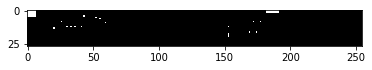

In [106]:
plt.imshow(asd, cmap='gray', vmin=0, vmax=1)